It is clear that to train this kind of models we need contiguous in time images.
We need to figure out a nice way to do this, we cannot simply take the \(k\) previous images because there are some temporal holes between a rainfall and another.
We could give an id to the storms, divide in sequences the storms, which means that when we meet 2 images that are more than 5 minutes temporally spaced we consider the 2 images belonging to different storms. then, in training and choosing epochs we choose randomly one storm and randomly again we choose \(k\) contiguous images of that storm to predict the \(k\)-th.

In [1]:
import requests
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

In [2]:
id_df = pd.read_csv('id_df_final.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/images/image.jpg'

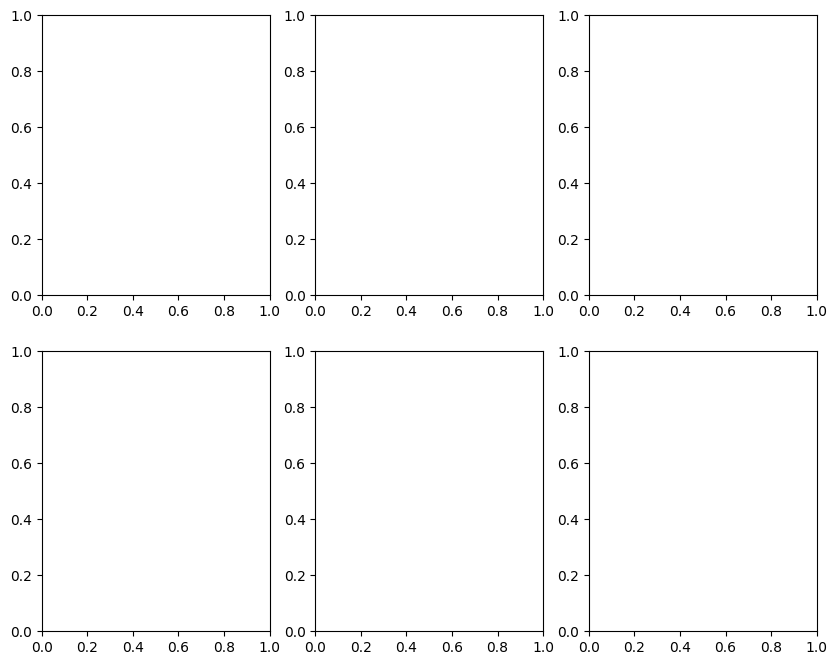

In [17]:
k = 5 # number of images to display

seq_id = id_df.sample(1)['sequence'].values[0]
# get k ids of the same sequence of contiguous frames
frames = id_df[id_df['sequence'] == seq_id]
seq_len = len(frames)
start_idx = np.random.randint(0, seq_len - k)
frames = frames[start_idx:start_idx + k]

predicted_image_path = f"../data/images/image.jpg"

#images_paths = [f"../data/images/{row.id}.jpg" for row in frames.itertuples()]
images_paths = [f"../data/images/image.jpg" for row in frames.itertuples()]
images_paths.append(predicted_image_path)

fig, axes = plt.subplots(2, k//2+1, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(images_paths[i])
    ax.imshow(img)
    ax.axis('off')
    if i < k:
        ax.set_title(f"Frame {i+1}")
    else:
        ax.set_title("Predicted Frame")
    

## dataset creation

In [3]:
id_df = id_df[['id', 'sequence']]

In [4]:
# create a dataframe with the ids of the images
id_seq_dataset = pd.DataFrame()

k_in = 10 # number of images to predict the next one
k_out = 10

# get k_in ids of the same sequence to predict the k_out ones
for i in id_df['sequence'].unique():
    print(i)
    seq_id = i
    len_seq = len(id_df[id_df['sequence'] == seq_id])
    frames = id_df[id_df['sequence'] == seq_id]
    for j in range(len_seq - k_in - k_out -1):
        k_frames = frames.iloc[j:j+k_in]['id'].to_list()
        id_frames_to_pred = frames.iloc[j+k_in:j+k_in+k_out]['id'].to_list()
        k_frames = k_frames + id_frames_to_pred
        k_frames.append(seq_id)
        id_seq_dataset = pd.concat([id_seq_dataset, pd.Series(k_frames)], ignore_index=True, axis=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


In [5]:
print(len(id_seq_dataset))
id_seq_dataset = id_seq_dataset.T
print(len(id_seq_dataset))
id_seq_dataset

21
14081


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,2455220,2455200,2455180,2455162,2455140,2455120,2455080,2455060,2455040,2455020,...,2454980,2454940,2454920,2454900,2454880,2454862,2454840,2454800,2454780,0
1,2455200,2455180,2455162,2455140,2455120,2455080,2455060,2455040,2455020,2455002,...,2454940,2454920,2454900,2454880,2454862,2454840,2454800,2454780,2454762,0
2,2455180,2455162,2455140,2455120,2455080,2455060,2455040,2455020,2455002,2454980,...,2454920,2454900,2454880,2454862,2454840,2454800,2454780,2454762,2454742,0
3,2455162,2455140,2455120,2455080,2455060,2455040,2455020,2455002,2454980,2454940,...,2454900,2454880,2454862,2454840,2454800,2454780,2454762,2454742,2454722,0
4,2455140,2455120,2455080,2455060,2455040,2455020,2455002,2454980,2454940,2454920,...,2454880,2454862,2454840,2454800,2454780,2454762,2454742,2454722,2454700,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14076,1951625,1951608,1951588,1951568,1951548,1951528,1951509,1951481,1951463,1951445,...,1951409,1951391,1951372,1951350,1951335,1951317,1951299,1951281,1951253,147
14077,1951608,1951588,1951568,1951548,1951528,1951509,1951481,1951463,1951445,1951427,...,1951391,1951372,1951350,1951335,1951317,1951299,1951281,1951253,1951235,147
14078,1951588,1951568,1951548,1951528,1951509,1951481,1951463,1951445,1951427,1951409,...,1951372,1951350,1951335,1951317,1951299,1951281,1951253,1951235,1951216,147
14079,1951568,1951548,1951528,1951509,1951481,1951463,1951445,1951427,1951409,1951391,...,1951350,1951335,1951317,1951299,1951281,1951253,1951235,1951216,1951201,147


In [7]:
# rename the columns: image_0, image_1, image_2, image_3, image_4, image_pred, seq_id

col_names = [f"input_{i}" for i in range(0, k_in)]
col_names = col_names + [f"output_{i}" for i in range(0, k_out)]
col_names = col_names + ["seq_id"]

id_seq_dataset.columns = col_names
id_seq_dataset

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,...,output_1,output_2,output_3,output_4,output_5,output_6,output_7,output_8,output_9,seq_id
0,2455220,2455200,2455180,2455162,2455140,2455120,2455080,2455060,2455040,2455020,...,2454980,2454940,2454920,2454900,2454880,2454862,2454840,2454800,2454780,0
1,2455200,2455180,2455162,2455140,2455120,2455080,2455060,2455040,2455020,2455002,...,2454940,2454920,2454900,2454880,2454862,2454840,2454800,2454780,2454762,0
2,2455180,2455162,2455140,2455120,2455080,2455060,2455040,2455020,2455002,2454980,...,2454920,2454900,2454880,2454862,2454840,2454800,2454780,2454762,2454742,0
3,2455162,2455140,2455120,2455080,2455060,2455040,2455020,2455002,2454980,2454940,...,2454900,2454880,2454862,2454840,2454800,2454780,2454762,2454742,2454722,0
4,2455140,2455120,2455080,2455060,2455040,2455020,2455002,2454980,2454940,2454920,...,2454880,2454862,2454840,2454800,2454780,2454762,2454742,2454722,2454700,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14076,1951625,1951608,1951588,1951568,1951548,1951528,1951509,1951481,1951463,1951445,...,1951409,1951391,1951372,1951350,1951335,1951317,1951299,1951281,1951253,147
14077,1951608,1951588,1951568,1951548,1951528,1951509,1951481,1951463,1951445,1951427,...,1951391,1951372,1951350,1951335,1951317,1951299,1951281,1951253,1951235,147
14078,1951588,1951568,1951548,1951528,1951509,1951481,1951463,1951445,1951427,1951409,...,1951372,1951350,1951335,1951317,1951299,1951281,1951253,1951235,1951216,147
14079,1951568,1951548,1951528,1951509,1951481,1951463,1951445,1951427,1951409,1951391,...,1951350,1951335,1951317,1951299,1951281,1951253,1951235,1951216,1951201,147


In [8]:
id_seq_dataset.to_csv('../data/id_seq_dataset.csv', index=False)